# Objective
    1) Remove test images without defect from Step1
    2) Remove train images without defect (Only use the train images with defect(s) for training)
    2) Predict Mask

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

# df_test
## Remove test images without defect from Step1

In [2]:
test = pd.read_csv('./output/submission_step1.csv')
test['EncodedPixels_1'] = np.nan
test['EncodedPixels_2'] = np.nan
test['EncodedPixels_3'] = np.nan
test['EncodedPixels_4'] = np.nan

print("test.shape:", test.shape)
test.head()

test.shape: (1801, 6)


,ImageId,defect,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
0,004f40c73.jpg,True,NaN,NaN,NaN,NaN
1,006f39c41.jpg,True,NaN,NaN,NaN,NaN
2,00b7fb703.jpg,False,NaN,NaN,NaN,NaN
3,00bbcd9af.jpg,True,NaN,NaN,NaN,NaN
4,0108ce457.jpg,False,NaN,NaN,NaN,NaN


In [3]:
test1 = test[test['defect']==True]    #predict
test0 = test[test['defect']==False]   #done

In [4]:
# test3 = pd.concat([test1 ,test0], axis=0)
# test3 = test3.sort_index()

# print("test3.shape:", test3.shape)
# test3.head()

# df_train

In [5]:
train = pd.read_csv('./input/train.csv')
print("train.shape:", train.shape)
train.head()

train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


## 1) Split into ImageId, ClassId

In [8]:
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['defect'] = train['EncodedPixels'].notnull()

train = train[['ImageId','ClassId','defect','EncodedPixels']]

In [9]:
print('{} = no. of train_images * 4'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

50272 = no. of train_images * 4
train.shape: (50272, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


## 2) Remove train images without defect
    Only use the train images with defect(s) for training

In [10]:
train = train[train['defect']==True]

print('There are {} masks in total'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

There are 7095 masks in total
train.shape: (7095, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...


3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64


Text(0, 0.5, 'No. of images')

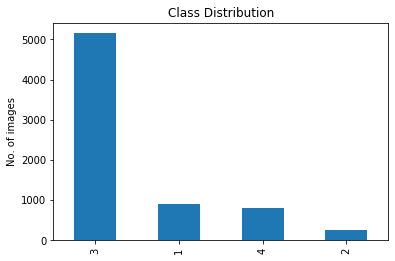

In [11]:
print(train['ClassId'].value_counts())   # for checking

train['ClassId'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("No. of images")

In [12]:
def rle2mask(rle, imgshape = (256,1600)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

## 3) Split into EncodedPixels_1/2/3/4 columns

In [13]:
train['EncodedPixels_1'] = np.nan
train['EncodedPixels_2'] = np.nan
train['EncodedPixels_3'] = np.nan
train['EncodedPixels_4'] = np.nan

print('train.shape:', train.shape)
train.head()

train.shape: (7095, 8)


,ImageId,ClassId,defect,EncodedPixels,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,NaN
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,NaN,NaN,NaN
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,NaN
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...,NaN,NaN,NaN,NaN
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...,NaN,NaN,NaN,NaN


In [14]:
train['EncodedPixels_1'] = train[train['ClassId'] == str(1)]['EncodedPixels']
train['EncodedPixels_2'] = train[train['ClassId'] == str(2)]['EncodedPixels']
train['EncodedPixels_3'] = train[train['ClassId'] == str(3)]['EncodedPixels']
train['EncodedPixels_4'] = train[train['ClassId'] == str(4)]['EncodedPixels']

print('train.shape:', train.shape)
train.head(8)

train.shape: (7095, 8)


,ImageId,ClassId,defect,EncodedPixels,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN
46,0025bde0c.jpg,3,True,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,NaN
47,0025bde0c.jpg,4,True,315139 8 315395 15 315651 16 315906 17 316162 ...,NaN,NaN,NaN,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg,4,True,290800 6 291055 13 291311 15 291566 18 291822 ...,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...


In [15]:
print('ClassId == 1:', train['EncodedPixels_1'].count())   # checking
print('ClassId == 2:', train['EncodedPixels_2'].count())
print('ClassId == 3:', train['EncodedPixels_3'].count())
print('ClassId == 4:', train['EncodedPixels_4'].count())

ClassId == 1: 897
ClassId == 2: 247
ClassId == 3: 5150
ClassId == 4: 801


In [16]:
train.drop(['ClassId', 'EncodedPixels'], axis = 1, inplace = True)

In [17]:
print('train.shape:', train.shape)
train.head()

train.shape: (7095, 6)


,ImageId,defect,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
0,0002cc93b.jpg,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
18,0007a71bf.jpg,True,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN
20,000a4bcdd.jpg,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN
27,000f6bf48.jpg,True,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,True,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN


## 4) Merge duplicated rows

In [18]:
y_train = train.groupby(by='ImageId').agg({'defect':'sum', 'EncodedPixels_1':'first', 'EncodedPixels_2':'first', 'EncodedPixels_3':'first', 'EncodedPixels_4':'first'})

print('There are {} train images with defect(s) in total'.format(y_train.shape[0]))
print('train.shape:', y_train.shape)
y_train.head(8)

There are 6666 train images with defect(s) in total
train.shape: (6666, 5)


,defect,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
ImageId,,,,,
0002cc93b.jpg,1.0,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
0007a71bf.jpg,1.0,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN
000a4bcdd.jpg,1.0,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN
000f6bf48.jpg,1.0,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...
0014fce06.jpg,1.0,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN
0025bde0c.jpg,2.0,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...
002af848d.jpg,1.0,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...
002fc4e19.jpg,2.0,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN


1.0    6239
2.0     425
3.0       2
Name: defect, dtype: int64
Ratio: 14.611241


Text(0, 0.5, 'No. of images')

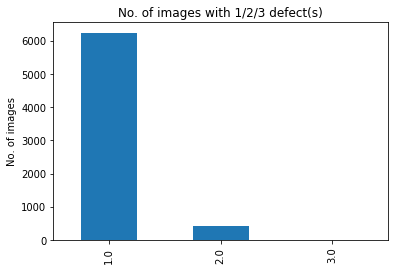

In [19]:
print(y_train['defect'].value_counts())
print('Ratio: {:f}'.format(y_train['defect'].value_counts()[1]/ (y_train['defect'].value_counts()[2]+y_train['defect'].value_counts()[3]) ))

y_train['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with 1/2/3 defect(s)")
plt.ylabel("No. of images")

# Split train into y_train, y_val 

In [20]:
VALIDATION_SPLIT = 0.1

In [21]:
from sklearn.model_selection import train_test_split

y_train, y_val = train_test_split(y_train, test_size=VALIDATION_SPLIT, random_state=63)

In [22]:
print('y_train.shape:', y_train.shape)
y_train.head()

y_train.shape: (5999, 5)


,defect,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
ImageId,,,,,
3a773f5e3.jpg,1.0,NaN,NaN,149505 23 149761 69 150017 114 150273 159 1505...,NaN
01919944c.jpg,1.0,NaN,NaN,55 19 225 13 283 57 459 39 524 81 699 59 776 9...,NaN
3888ec2cd.jpg,1.0,93849 2 94103 6 94356 10 94610 14 94864 17 951...,NaN,NaN,NaN
f36bc094e.jpg,1.0,NaN,NaN,164907 7 165163 21 165418 35 165674 49 165929 ...,NaN
7f1b37606.jpg,2.0,NaN,NaN,82009 27 82222 81 82435 134 82691 140 82947 14...,128221 16 128447 46 128687 63 128942 64 129196...


1.0    5624
2.0     374
3.0       1
Name: defect, dtype: int64
Ratio: 14.997333


Text(0, 0.5, 'No. of images')

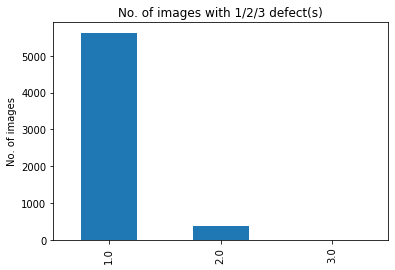

In [23]:
print(y_train['defect'].value_counts())
print('Ratio: {:f}'.format(y_train['defect'].value_counts()[1]/ (y_train['defect'].value_counts()[2]+y_train['defect'].value_counts()[3])))

y_train['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with 1/2/3 defect(s)")
plt.ylabel("No. of images")

In [24]:
print('y_val.shape:', y_val.shape)
y_val.head()

y_val.shape: (667, 5)


,defect,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
ImageId,,,,,
193eeae52.jpg,1.0,NaN,NaN,150273 55 150529 110 150785 111 151041 111 151...,NaN
5d1d529b0.jpg,1.0,NaN,NaN,56323 64 56579 190 56835 254 57091 254 57347 2...,NaN
b41ab39a5.jpg,1.0,NaN,NaN,322111 3 322353 2 322363 10 322601 12 322616 1...,NaN
9d77811eb.jpg,1.0,NaN,NaN,139781 126 140037 252 140293 252 140550 251 14...,NaN
002fc4e19.jpg,2.0,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN


1.0    615
2.0     51
3.0      1
Name: defect, dtype: int64
Ratio: 11.826923


Text(0, 0.5, 'No. of images')

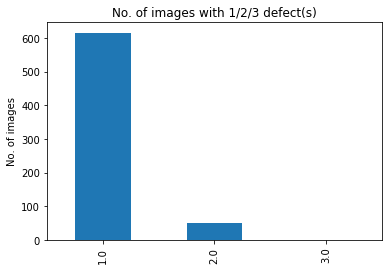

In [25]:
print(y_val['defect'].value_counts())
print('Ratio: {:f}'.format(y_val['defect'].value_counts()[1]/(y_val['defect'].value_counts()[2]+y_val['defect'].value_counts()[3])))

y_val['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with 1/2/3 defect(s)")
plt.ylabel("No. of images")

# ImageDataGenerator
1. Data Augmentation for train_images (i.e. rotate, shear, flip...)
2. Create flow from dataframe (Takes the dataframe and the path to a directory and generates batches of augmented/normalized data.)

In [20]:
BATCH_SIZE = 32

In [21]:
%%time
from keras.preprocessing.image import ImageDataGenerator

# Create train data generator (Data augementation: i.e. rotate, shear, flip...) 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        
        #fill_mode='constant',   # filling points outside the input boundaries with 0
        #cval=0.,
        #zoom_range=0.1,
        #rotation_range=10,
        #height_shift_range=0.1,
        #width_shift_range=0.1,
        #horizontal_flip=True,
        #vertical_flip=True
)

# Create flow from dataframe for train set
train_generator = train_datagen.flow_from_dataframe(
        y_train,
        directory = './input/train_images/',
        x_col='ImageId', 
        y_col='defect', 
        target_size = (256,256),
        color_mode = 'rgb',
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle=True)


# Create data generator for val & test set (rescale only)
val_test_datagen = ImageDataGenerator(
        rescale=1./255
)

# Create flow from dataframe for val set
validation_generator = val_test_datagen.flow_from_dataframe(
        y_val,
        directory = './input/train_images/',
        x_col='ImageId', 
        y_col='defect',
        target_size = (256,256),
        color_mode = 'rgb',
        batch_size = BATCH_SIZE,
        class_mode = 'binary',
        shuffle=False)

# Create flow from dataframe for test set
test_generator = val_test_datagen.flow_from_dataframe(
        sample_submission,
        directory = './input/test_images/',
        x_col='ImageId',
        target_size = (256,256),
        color_mode = 'rgb',
        batch_size = BATCH_SIZE,
        class_mode = None,
        shuffle=False)

Using TensorFlow backend.


Found 11311 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.
Found 1801 validated image filenames.
Wall time: 3.03 s


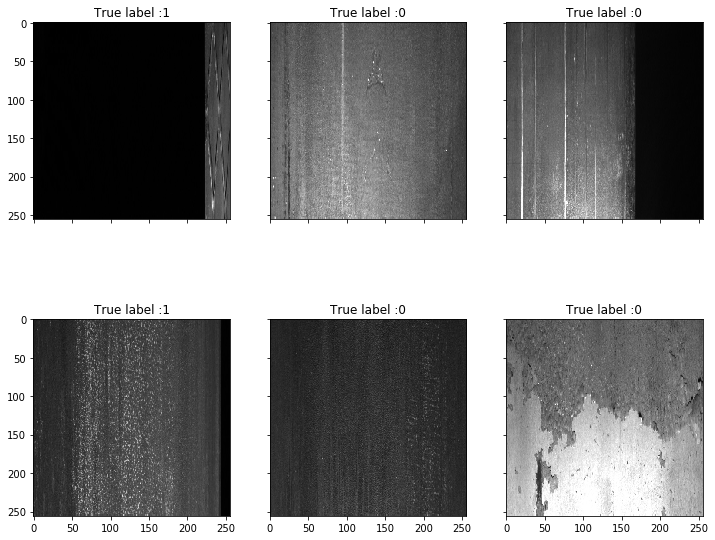

In [22]:
# show train data generator (with Data Augmentation)
nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col

        ax[row,col].imshow(train_generator[0][0][i])
        ax[row,col].set_title("True label :{}".format(train_generator.classes[i]))

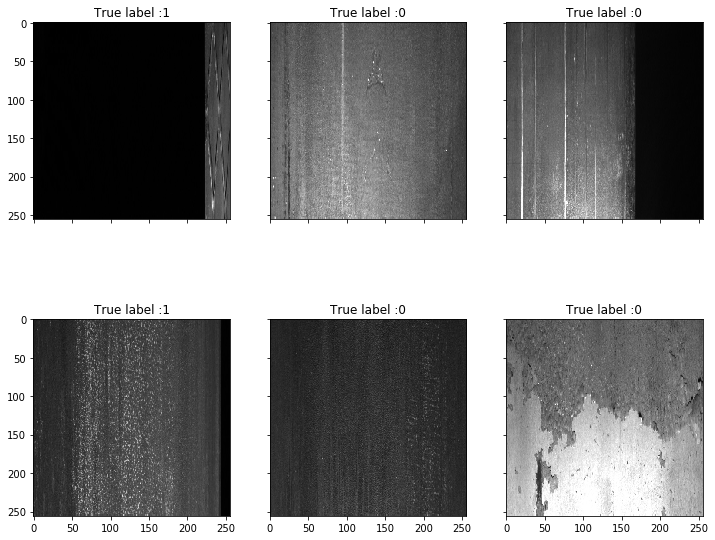

In [23]:
# show train data generator
nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col

        ax[row,col].imshow(train_generator[0][0][i])
        ax[row,col].set_title("True label :{}".format(train_generator.classes[i]))

# Model in Keras

In [24]:
import keras
from keras.layers import Dropout, BatchNormalization, Flatten, Dense, GlobalMaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, Input, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.applications import DenseNet121, Xception, InceptionResNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import tensorflow as tf

In [25]:
# # Set cpu cores = 1

# from keras import backend as K
# K.set_session(K.tf.Session(config=K.tf.ConfigProto(device_count = {'CPU' : 1, 'GPU': 1},
#                                                    intra_op_parallelism_threads = 4,
#                                                    inter_op_parallelism_threads = 4,
#                                                    )))

In [26]:
KEEP_PROB = 0.3

In [27]:
def Create_model():
    
    input_shape = (256,256,3)
    
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization() (c1)
    c1 = Activation('elu') (c1)
    c1 = Conv2D(8, (3, 3), padding='same') (c1)
    c1 = BatchNormalization() (c1)
    c1 = Activation('elu') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(KEEP_PROB) (p1)

    c2 = Conv2D(16, (3, 3), padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Activation('elu') (c2)
    c2 = Conv2D(16, (3, 3), padding='same') (c2)
    c2 = BatchNormalization() (c2)
    c2 = Activation('elu') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(KEEP_PROB) (p2)

    c3 = Conv2D(32, (3, 3), padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Activation('elu') (c3)
    c3 = Conv2D(32, (3, 3), padding='same') (c3)
    c3 = BatchNormalization() (c3)
    c3 = Activation('elu') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(KEEP_PROB) (p3)

    c4 = Conv2D(64, (3, 3), padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Activation('elu') (c4)
    c4 = Conv2D(64, (3, 3), padding='same') (c4)
    c4 = BatchNormalization() (c4)
    c4 = Activation('elu') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(KEEP_PROB) (p4)

    c5 = Conv2D(64, (3, 3), padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Activation('elu') (c5)
    c5 = Conv2D(64, (3, 3), padding='same') (c5)
    c5 = BatchNormalization() (c5)
    c5 = Activation('elu') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
    p5 = Dropout(KEEP_PROB) (p5)

    c55 = Conv2D(128, (3, 3), padding='same') (p5)
    c55 = BatchNormalization() (c55)
    c55 = Activation('elu') (c55)
    c55 = Conv2D(128, (3, 3), padding='same') (c55)
    c55 = BatchNormalization() (c55)
    c55 = Activation('elu') (c55)

#     u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
#     u6 = concatenate([u6, c5])
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

#     u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
#     u71 = concatenate([u71, c4])
#     c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
#     c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

#     u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

#     u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

#     u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)
    
#     c9 = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    
#     outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    x1 = GlobalMaxPooling2D() (c55)
    x1 = BatchNormalization() (x1)
    x1 = Dropout(KEEP_PROB) (x1)
    
    outputs = Dense(1, activation = 'sigmoid') (x1)
    
#     x1 = GlobalAveragePooling2D() (c9)
#     x1 = BatchNormalization() (x1)
#     x1 = Dropout(KEEP_PROB) (x1)
    
#     x2 = Dense(2048, activation = 'relu') (x1)
#     x2 = BatchNormalization() (x2)
#     x2 = Dropout(KEEP_PROB) (x2)
    
#     x3 = Dense(512, activation = 'relu') (x2)
#     x3 = BatchNormalization() (x3)
#     x3 = Dropout(KEEP_PROB) (x3)
    
#     outputs = Dense(1, activation = 'sigmoid') (x3)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [28]:
# def Create_model():
    
#     input_shape = (256,256,3)
    
#     inputs = Input(input_shape)

#     c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
#     c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
#     p1 = MaxPooling2D((2, 2)) (c1)
#     p1 = Dropout(KEEP_PROB) (p1)

#     c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
#     c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
#     p2 = MaxPooling2D((2, 2)) (c2)
#     p2 = Dropout(KEEP_PROB) (p2)

#     c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
#     c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
#     p3 = MaxPooling2D((2, 2)) (c3)
#     p3 = Dropout(KEEP_PROB) (p3)

#     c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
#     c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
#     p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
#     p4 = Dropout(KEEP_PROB) (p4)

#     c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
#     c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
#     p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
#     p5 = Dropout(KEEP_PROB) (p5)

#     c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
#     c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

# #     u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
# #     u6 = concatenate([u6, c5])
# #     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
# #     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

# #     u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
# #     u71 = concatenate([u71, c4])
# #     c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
# #     c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

# #     u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
# #     u7 = concatenate([u7, c3])
# #     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
# #     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

# #     u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
# #     u8 = concatenate([u8, c2])
# #     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
# #     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

# #     u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
# #     u9 = concatenate([u9, c1], axis=3)
# #     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
# #     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)
    
# #     c9 = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    
# #     outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

#     x1 = GlobalMaxPooling2D() (c55)
#     x1 = BatchNormalization() (x1)
#     x1 = Dropout(KEEP_PROB) (x1)
    
#     outputs = Dense(1, activation = 'sigmoid') (x1)
    
# #     x1 = GlobalAveragePooling2D() (c9)
# #     x1 = BatchNormalization() (x1)
# #     x1 = Dropout(KEEP_PROB) (x1)
    
# #     x2 = Dense(2048, activation = 'relu') (x1)
# #     x2 = BatchNormalization() (x2)
# #     x2 = Dropout(KEEP_PROB) (x2)
    
# #     x3 = Dense(512, activation = 'relu') (x2)
# #     x3 = BatchNormalization() (x3)
# #     x3 = Dropout(KEEP_PROB) (x3)
    
# #     outputs = Dense(1, activation = 'sigmoid') (x3)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     model.summary()
    
#     return model

In [29]:
def Load_model():
    keras.backend.clear_session()
    
    model = load_model('./model/unet_valacc.h5')
    #model.layers[0].trainable = False

    model.compile(
            loss = 'binary_crossentropy',
            optimizer = 'Adam',
            metrics = ['accuracy'])
    
    model.summary()
    
    return model

In [30]:
%%time
# Create model
# model = Create_model()

# Load model
model = Load_model()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization_14 (Batc (None, 256, 256, 8)       32        
_________________________________________________________________
activation_13 (Activation)   (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________

In [32]:
# Define callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
# ModelCheckpoint: Save the (best) model weights after every epoch

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
             EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/unet_valacc.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False)
            ]

In [33]:
EPOCHS = 20

total_steps = y_train.shape[0] / BATCH_SIZE                # no. of train_images / batch size

train_steps = int(np.ceil(y_train.shape[0] / BATCH_SIZE))
validation_steps = int(np.ceil(y_val.shape[0] / BATCH_SIZE))
print('train_steps:', train_steps)                         # len(train_generator)
print('validation_steps:', validation_steps)               # len(validation_generator)

train_steps: 354
validation_steps: 40


In [34]:
%%time
# Train the model

history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_steps,
                epochs = EPOCHS,
                validation_data = validation_generator,
                validation_steps = validation_steps,
                callbacks = callbacks,
                workers=16,
                max_queue_size=50
                )

Epoch 1/20
354/354 [==============================] - 60s 169ms/step - loss: 0.1161 - acc: 0.9552 - val_loss: 0.1549 - val_acc: 0.9411
Epoch 2/20
354/354 [==============================] - 48s 136ms/step - loss: 0.0996 - acc: 0.9620 - val_loss: 0.1483 - val_acc: 0.9475
Epoch 3/20
354/354 [==============================] - 49s 138ms/step - loss: 0.1008 - acc: 0.9598 - val_loss: 0.1962 - val_acc: 0.9324
Epoch 4/20
354/354 [==============================] - 49s 139ms/step - loss: 0.1002 - acc: 0.9621 - val_loss: 0.1964 - val_acc: 0.9395
Epoch 5/20
354/354 [==============================] - 49s 139ms/step - loss: 0.0866 - acc: 0.9657 - val_loss: 0.1260 - val_acc: 0.9578
Epoch 6/20
354/354 [==============================] - 49s 138ms/step - loss: 0.0735 - acc: 0.9719 - val_loss: 0.1348 - val_acc: 0.9554
Epoch 7/20
354/354 [==============================] - 49s 139ms/step - loss: 0.0729 - acc: 0.9728 - val_loss: 0.1379 - val_acc: 0.9539
Epoch 8/20
354/354 [==============================] - 4

In [27]:
# Save model
model.save('./model/unet_BN_DO_noval_acc_0.9800.h5')

In [35]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


# Model Evaluation

## Plot Learning rate

learning rate: [0.001, 0.001, 0.001, 0.001, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025, 0.000125, 0.000125, 6.25e-05, 6.25e-05]


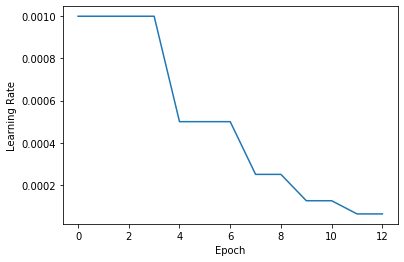

In [37]:
print('learning rate:', history.history['lr'])
plt.plot(history.history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

## 1) Plot loss and accuracy (train, val)

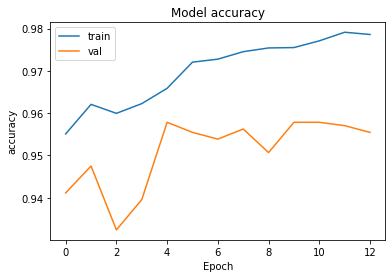

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.show()

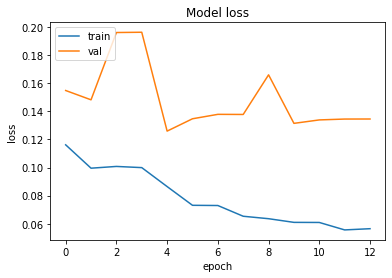

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 2) Loss and accuracy (val)

In [40]:
%%time

validation_generator.reset()
# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(validation_generator, steps = validation_steps)
print("loss:", score[0])
print("metric (accuracy): ", score[1])

loss: 0.13459698913741913
metric (accuracy):  0.9554494828957836
Wall time: 9.73 s


## 3) ROC AUC (val)

In [41]:
df_val = y_val
df_val.head()

,ImageId,defect
7313,94947e1f9.jpg,True
2119,2aeb8dbd6.jpg,False
8214,a6ecee828.jpg,True
357,07edbd095.jpg,False
5527,6fc6a0964.jpg,True


In [42]:
validation_generator.classes[:5]

[1, 0, 1, 0, 1]

In [43]:
validation_generator.filenames[:5]

['94947e1f9.jpg',
 '2aeb8dbd6.jpg',
 'a6ecee828.jpg',
 '07edbd095.jpg',
 '6fc6a0964.jpg']

In [49]:
%%time

validation_generator.reset()
# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(validation_generator, steps = validation_steps)

Wall time: 9.78 s


In [50]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

y_val_pred_prob.shape: (1257, 1)


array([[9.9999642e-01],
       [5.5263638e-03],
       [9.9675345e-01],
       ...,
       [3.9896369e-04],
       [9.9999344e-01],
       [9.3592912e-01]], dtype=float32)

In [51]:
y_val_pred = y_val_pred_prob > 0.5
y_val_pred

array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [52]:
y_val = np.array(validation_generator.classes)
print('y_val.shape:', y_val.shape)
y_val

y_val.shape: (1257,)


array([1, 0, 1, ..., 0, 1, 1])

In [53]:
from sklearn.metrics import roc_auc_score

print('ROC AUC (val): {0}'.format(roc_auc_score(y_val, y_val_pred)))

ROC AUC (val): 0.9554173397679266


## 4) Error Distribution

In [54]:
uniqueValues, occurCount = np.unique(y_val_pred, return_counts=True)

uniqueValues[0], uniqueValues[1] = uniqueValues[1], uniqueValues[0]     #reorder
occurCount[0], occurCount[1] = occurCount[1], occurCount[0]

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [ True False]
Occurrence Count :  [675 582]


True/False Ratio: 1.159794


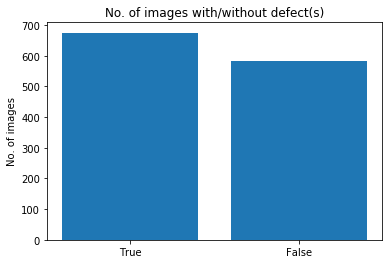

In [55]:
plt.bar(x = (str(uniqueValues[0]), str(uniqueValues[1])), height = occurCount)
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")
print('True/False Ratio: {:f}'.format(occurCount[0]/occurCount[1]))

## 5) Plot confusion matrix (val)

In [56]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, vmax=None, normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    print('confusion_matrix:\n', matrix)
    
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    fig = sns.heatmap(matrix, vmax=vmax, annot=True, square=True,
                cmap=plt.cm.Blues_r, cbar=False, linecolor='black', linewidths=1,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(title)
    plt.show(fig)

confusion_matrix:
 [[552  26]
 [ 30 649]]


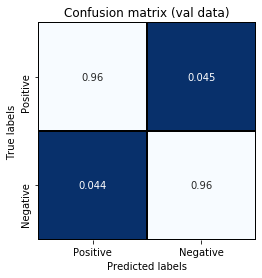

In [57]:
plot_confusion_matrix(y_val, y_val_pred,
                      class_names=['Positive', 'Negative'],
                      title='Confusion matrix (val data)')

## 6) Plot errors

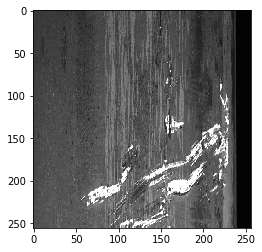

In [58]:
# image from validation_generator
validation_generator[38][0][31].shape   #1st[]: [0:39] no. of batch    2nd[]: [0/1] x/y    3nd[]: [0:32] no. of image in a batch
plt.imshow(validation_generator[38][0][31])

In [59]:
# last batch (40th): 9 images
validation_generator[39][0].shape

(9, 256, 256, 3)

In [60]:
# 1 batch = 32 images
validation_generator[0][0][:].shape

(32, 256, 256, 3)

In [61]:
%%time
x_val = np.concatenate([validation_generator[batch][0][:] for batch in range(len(validation_generator))])   # from 0 to 39
print('x_val.shape:', x_val.shape)

x_val.shape: (1257, 256, 256, 3)
Wall time: 10.1 s


Total no. of error in val set: 56
First 6 error index: [ 7 14 49 56 61 72]


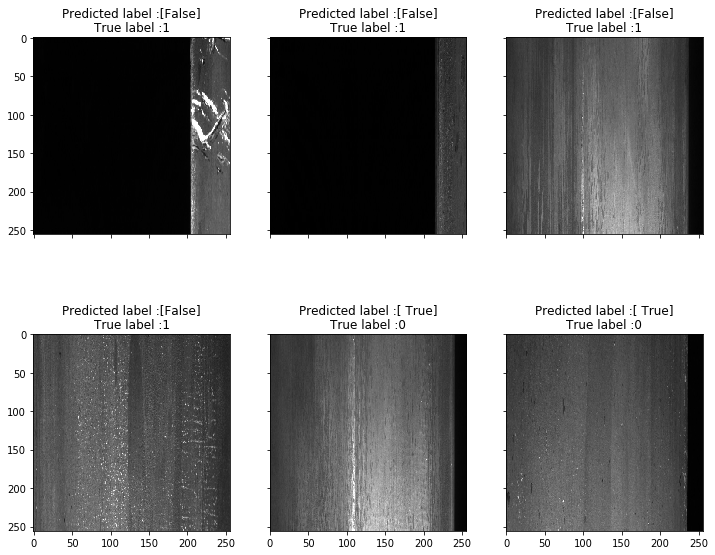

In [62]:
errors = (np.squeeze(y_val_pred) - y_val != 0) # array of bools with true when there is an error or false when the image is cor

index = np.squeeze(np.where(errors==True))
print('Total no. of error in val set:', len(index))
print('First 6 error index:', index[:6])

y_val_pred_er = y_val_pred[errors]
y_val_er = y_val[errors]
x_val_er = x_val[errors]

def display_errors():
    """ This function shows 6 images with their predicted and real labels"""
    nrows = 2
    ncols = 3
    
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
    for row in range(nrows):
        for col in range(ncols):
            i = row * ncols + col
            
            ax[row,col].imshow(x_val_er[i], )
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(y_val_pred_er[i], y_val_er[i]))

# Show the 6 errors
display_errors()

# Prediction

In [73]:
test_steps = int(np.ceil(sample_submission.shape[0] / BATCH_SIZE))           # no. of test_images / batch size
print('test_steps:', test_steps)                                             # len(test_generator)

test_steps: 57


In [74]:
%%time

test_generator.reset()
y_pred_prob = model.predict_generator(test_generator, steps = test_steps)

Wall time: 12.8 s


In [75]:
print('y_pred_prob.shape:', y_pred_prob.shape)
y_pred_prob

y_pred_prob.shape: (1801, 1)


array([[0.82347405],
       [0.7372708 ],
       [0.14082676],
       ...,
       [0.99832964],
       [0.00101423],
       [0.9997396 ]], dtype=float32)

In [76]:
y_pred = y_pred_prob > 0.5
y_pred

array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

# Sample_submission
    sample_submission['defect'] = y_pred

In [77]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,True
1,006f39c41.jpg,True
2,00b7fb703.jpg,False
3,00bbcd9af.jpg,True
4,0108ce457.jpg,False


In [78]:
sample_submission['defect'] = y_pred

In [79]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,True
1,006f39c41.jpg,True
2,00b7fb703.jpg,False
3,00bbcd9af.jpg,True
4,0108ce457.jpg,False


In [80]:
sample_submission.isnull().sum()

ImageId    0
defect     0
dtype: int64

True     1115
False     686
Name: defect, dtype: int64
True/False Ratio: 1.625364


Text(0, 0.5, 'No. of images')

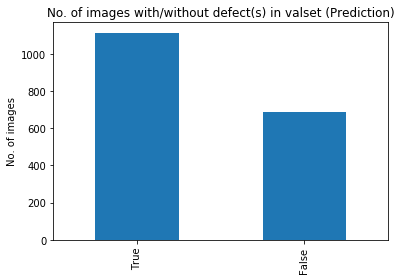

In [83]:
print(sample_submission['defect'].value_counts())
print('True/False Ratio: {:f}'.
      format(sample_submission['defect'].value_counts()[1]/sample_submission['defect'].value_counts()[0]))

sample_submission['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s) in valset (Prediction)")
plt.ylabel("No. of images")

In [72]:
sample_submission.to_csv('./output/submission_step2.csv', index=False)

# Plot Model png

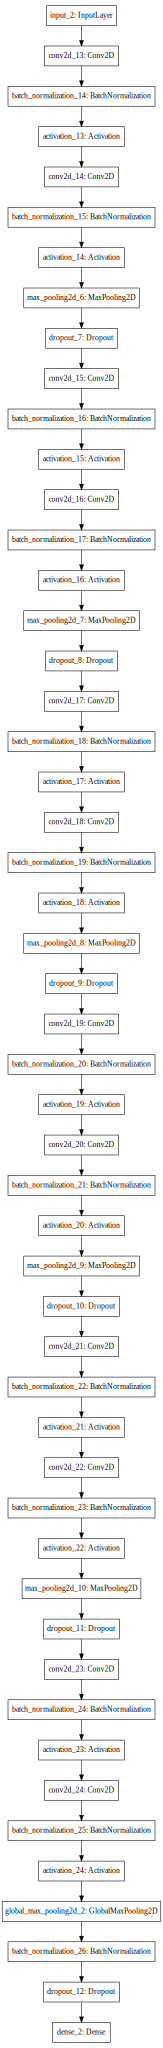

In [66]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='./output/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))